In [1]:
import os
# running from Root directory
os.chdir("..")

In [2]:
from connectome import Connectome
from connectome_network import ConnectomeNetwork
from connectome_types import SynapseSide, cell_types, ClfType, m_types
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import networkx as nx
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
clf_type_space = [e.value for e in ClfType]

In [3]:
Conn = Connectome()
neurons = Conn.neurons
synapses = Conn.synapses

Connectome:
	#neurons: 71736
	#synapses: 13506902


## Connectome Validations

In [4]:
from tqdm.notebook import trange, tqdm
invalid_ = 0
post_neurons_with_failed_sk = set()
synapses_without_dist_to_soma = 0

for syn in tqdm(synapses):
    if syn.pre_pt_root_id not in neurons or syn.post_pt_root_id not in neurons:
        invalid_ += 1

    if not hasattr(syn, 'dist_to_post_syn_soma') or syn.dist_to_post_syn_soma == -1.0:
        # print(f'invalid syn dist: {syn.id_}, {syn.pre_pt_root_id}, {syn.post_pt_root_id}')
        post_neurons_with_failed_sk.add(syn.post_pt_root_id)
        synapses_without_dist_to_soma += 1
    elif syn.pre_pt_root_id not in neurons:
        print(f'invalid syn pre: {syn.id_}, {syn.pre_pt_root_id}, {syn.post_pt_root_id}')
    elif syn.post_pt_root_id not in neurons:
        print(f'invalid syn post: {syn.id_}, {syn.pre_pt_root_id}, {syn.post_pt_root_id}')


print(f'#invalid synapses: {invalid_}')
print(f'#synapses_without_dist_to_soma: {synapses_without_dist_to_soma}')
print(f'#post_neurons_with_failed_sk: {len(post_neurons_with_failed_sk)}')

  0%|          | 0/13506902 [00:00<?, ?it/s]

#invalid synapses: 0
#synapses_without_dist_to_soma: 23614
#post_neurons_with_failed_sk: 67


## Netwrok & Neuron Distributions 

In [5]:
network = ConnectomeNetwork(Conn)
# network.basic_graph_plot()

Graph:
	#edges: 9008935
	#nodes: 71736


In [6]:
neuron_cell_types = [n.cell_type for n in neurons.values()]
neuron_m_types = [n.mtype for n in neurons.values()]
neuron_clf_types = [n.clf_type.value for n in neurons.values()]

In [7]:
def plot_neuron_type_dist(neuron_dist, subtitle):
    unique, counts = np.unique(neuron_dist, return_counts=True)
    bars = plt.bar(unique, counts)
    plt.xticks(range(len(unique)), unique, rotation=45)
    plt.xlabel('Neuron Types')
    plt.ylabel('Count')
    plt.title(f'Distribution of Neuron Types ({subtitle})')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, f'{height}', ha='center', va='bottom')
        
    plt.tight_layout()
    plt.show()

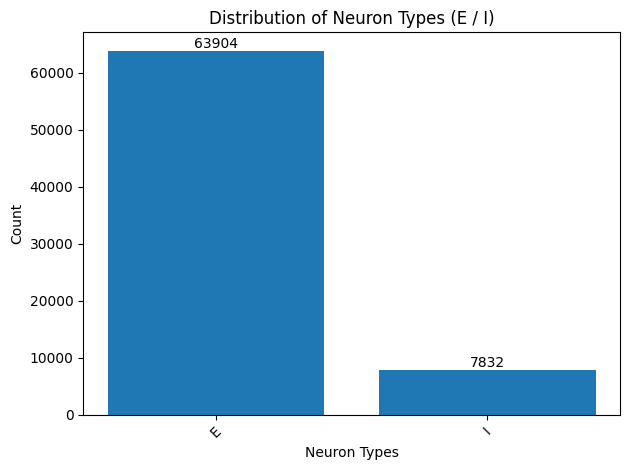

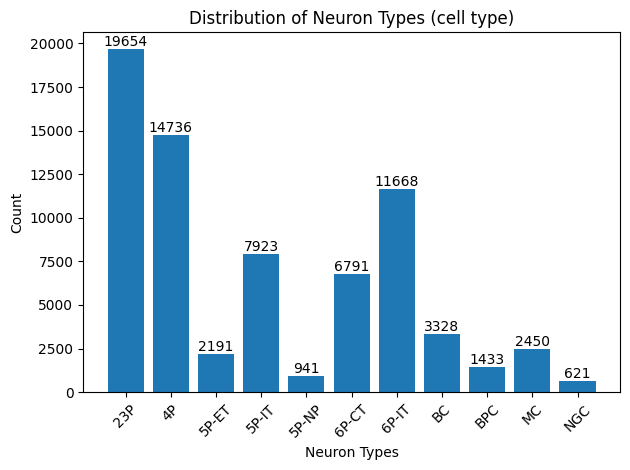

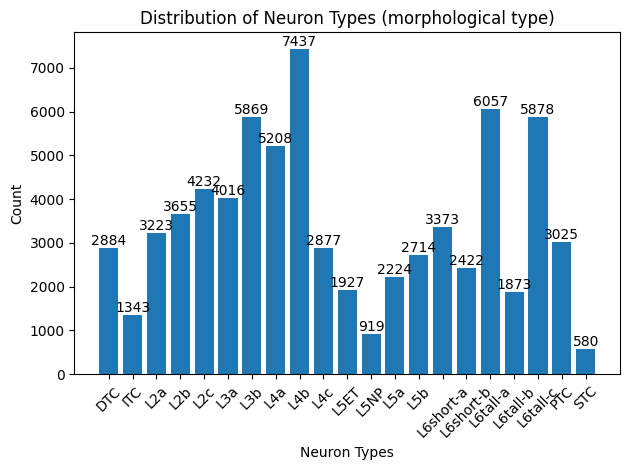

In [8]:
plot_neuron_type_dist(neuron_clf_types, 'E / I')
plot_neuron_type_dist(neuron_cell_types, 'cell type')
plot_neuron_type_dist(neuron_m_types, 'morphological type')

## Degree Distribution

In [9]:
in_degree = Conn.get_degree_distribution(SynapseSide.pre)
out_degree = Conn.get_degree_distribution(SynapseSide.post)

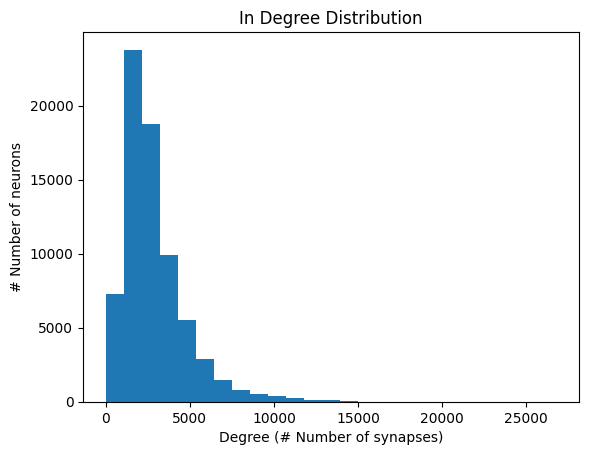

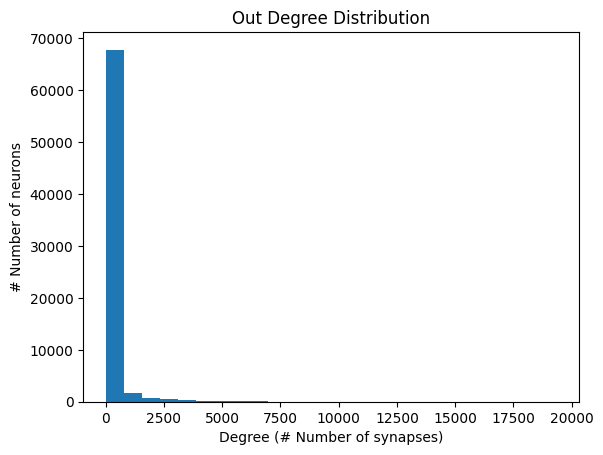

In [10]:
def degree_dist_plot(degree: list[int], sub_title: str):
    plt.hist(degree, bins=25)
    plt.xlabel('Degree (# Number of synapses)')
    plt.ylabel('# Number of neurons')
    plt.title(f'{sub_title} Distribution')
    plt.show()

degree_dist_plot(in_degree, 'In Degree')
degree_dist_plot(out_degree, 'Out Degree')

In [11]:
mtype_in_degree = Conn.get_cell_type_degree_distribution('mtype', m_types, SynapseSide.pre)
mtype_out_degree = Conn.get_cell_type_degree_distribution('mtype', m_types, SynapseSide.post)
cell_type_in_degree = Conn.get_cell_type_degree_distribution('cell_type', cell_types, SynapseSide.pre)
cell_type_out_degree = Conn.get_cell_type_degree_distribution('cell_type', cell_types, SynapseSide.post)
clftype_in_degree = Conn.get_cell_type_degree_distribution('clf_type', clf_type_space, SynapseSide.pre)
clftype_out_degree = Conn.get_cell_type_degree_distribution('clf_type', clf_type_space, SynapseSide.post)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71736/71736 [00:00<00:00, 1130869.73it/s]


In [12]:
def degree_dist_boxplot_types(data_dict, labels, title):
    # df_list = [pd.DataFrame({key: data_dict[key]}) for key in labels]
    labels = [key for key in labels if len(data_dict[key]) > 0]

    df_list = [pd.DataFrame({key: data_dict[key]}) for key in labels if len(data_dict[key]) > 0]
    df = pd.concat(df_list, keys=labels).reset_index(level=0).rename(columns={'level_0': 'Type'})
    df_melted = df.melt(id_vars=['Type'], var_name='Variable', value_name='Number of connections')
    
    plt.title(title)
    ax = sns.boxplot(y='Type', x='Number of connections', data=df_melted, order=labels)
    sums = df_melted.groupby('Type')['Number of connections'].count()
    ytick_labels = [f'{label} (N={sums[label]})' for label in labels]
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(ytick_labels)
    
    plt.tight_layout()
    plt.show()

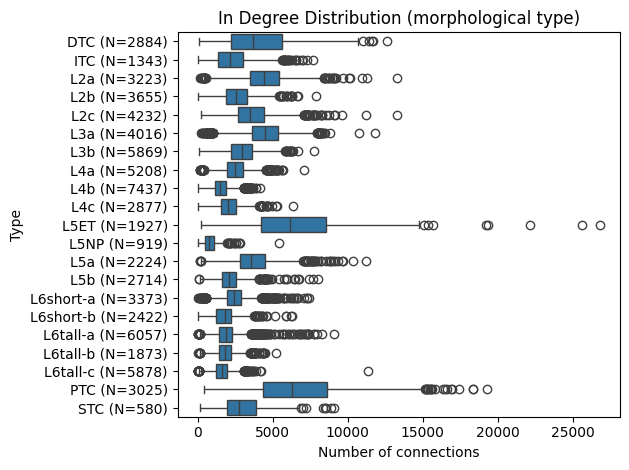

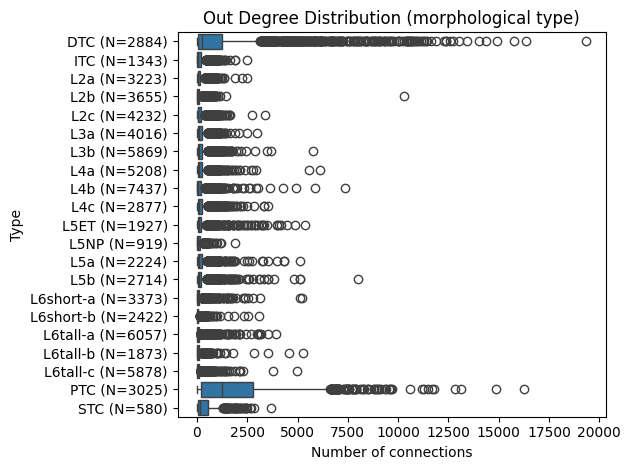

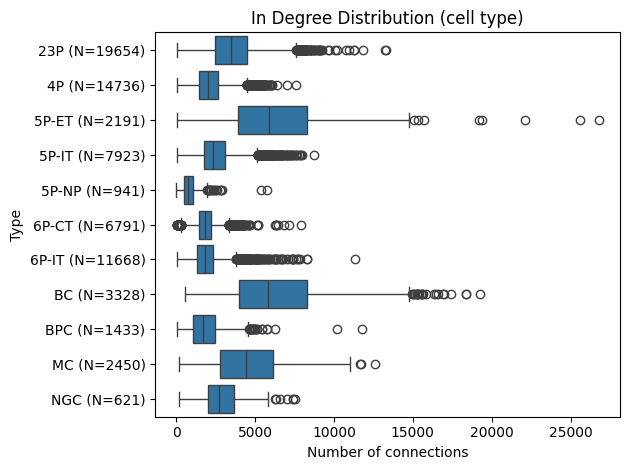

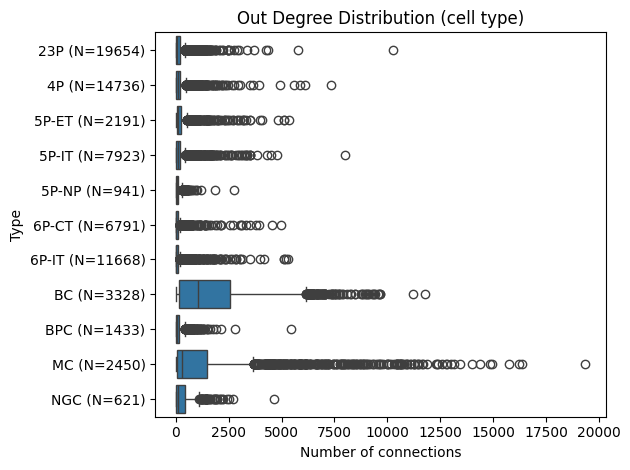

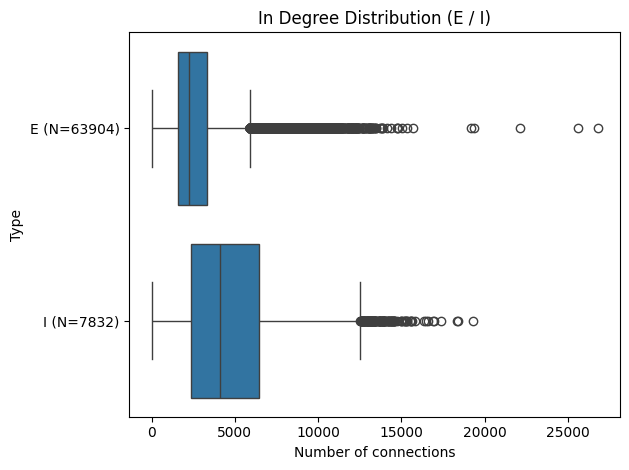

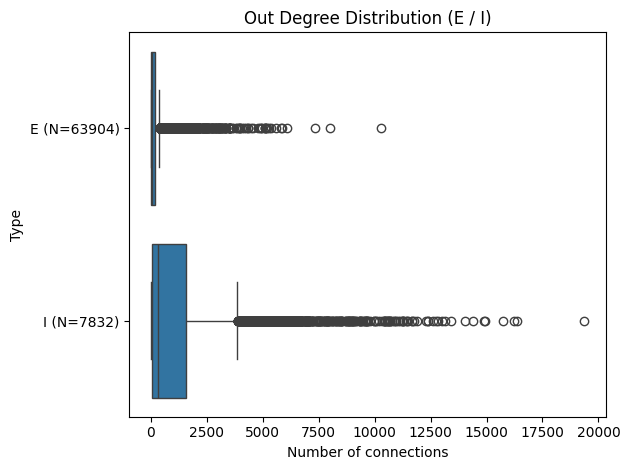

In [13]:
degree_dist_boxplot_types(mtype_in_degree, m_types, 'In Degree Distribution (morphological type)')
degree_dist_boxplot_types(mtype_out_degree, m_types, 'Out Degree Distribution (morphological type)')

degree_dist_boxplot_types(cell_type_in_degree, cell_types, 'In Degree Distribution (cell type)')
degree_dist_boxplot_types(cell_type_out_degree, cell_types, 'Out Degree Distribution (cell type)')

degree_dist_boxplot_types(clftype_in_degree, clf_type_space, 'In Degree Distribution (E / I)')
degree_dist_boxplot_types(clftype_out_degree, clf_type_space, 'Out Degree Distribution (E / I)')

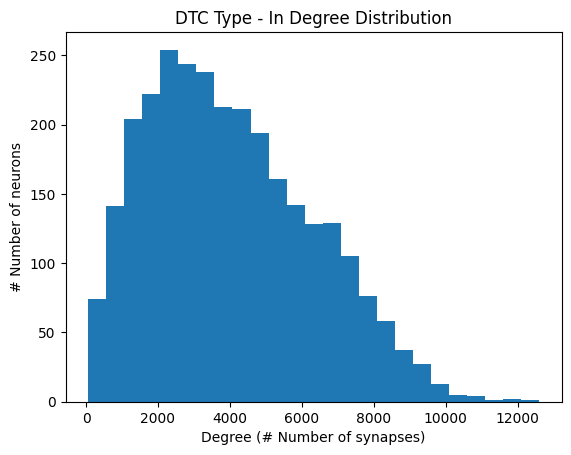

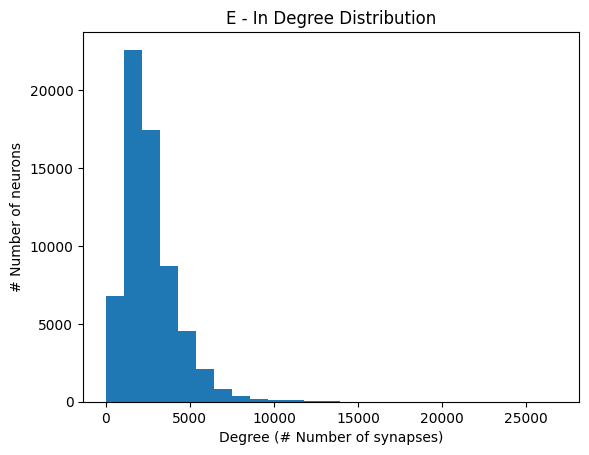

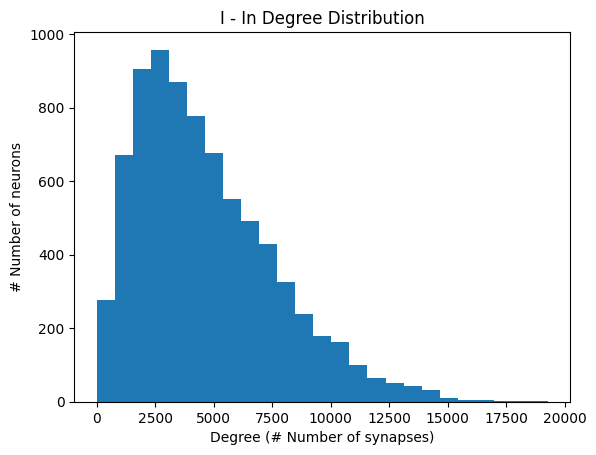

In [14]:
# dive deep for a specific type
degree_dist_plot(mtype_in_degree['DTC'], 'DTC Type - In Degree')
degree_dist_plot(clftype_in_degree['E'], 'E - In Degree')
degree_dist_plot(clftype_in_degree['I'], 'I - In Degree')

## Connectivity Matrix

In [15]:
mtype_mat = Conn.get_cell_type_conn_matrix('mtype', m_types)
celltype_mat = Conn.get_cell_type_conn_matrix('cell_type', cell_types)
clftype_mat = Conn.get_cell_type_conn_matrix('clf_type', clf_type_space)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13506902/13506902 [00:26<00:00, 502556.18it/s]


In [16]:
def plot_cell_type_conn_matrix(z, labels, title, remove=[], text_inside=False):
    non_empty_rows = ~np.all(z == 0, axis=1)
    non_empty_cols = ~np.all(z == 0, axis=0)
    z_filtered = z[non_empty_rows][:, non_empty_cols]
    labels_filtered = np.array(labels)[non_empty_rows]

    if remove:
        mask = ~np.isin(labels_filtered, remove)
        z_filtered = z_filtered[mask][:, mask]
        labels_filtered = labels_filtered[mask]
    
    c = plt.imshow(z_filtered, cmap ='YlOrRd') 
    plt.colorbar(c) 
    plt.title(f'{title}', fontweight ="bold") 
    plt.xticks(ticks=np.arange(len(labels_filtered)), labels=labels_filtered,  rotation=90)
    plt.yticks(ticks=np.arange(len(labels_filtered)), labels=labels_filtered)
    plt.ylabel('Postsynaptic neuron type'); plt.xlabel('Presynaptic neuron type');

    if text_inside:
        for i in range(z.shape[0]):
            for j in range(z.shape[1]):
                plt.text(j, i, f'{z[i, j]:.2f}', ha='center', va='center', color='black')
    plt.show() 

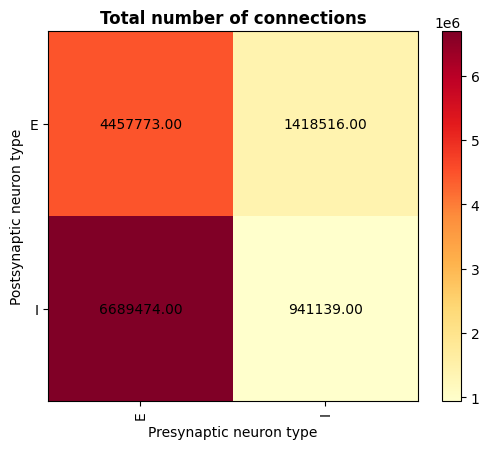

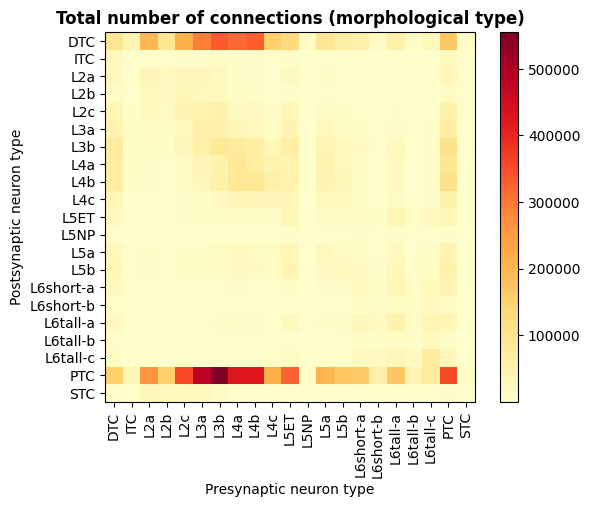

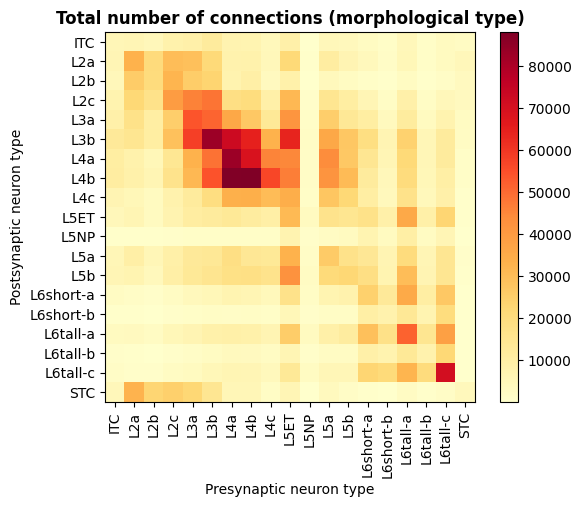

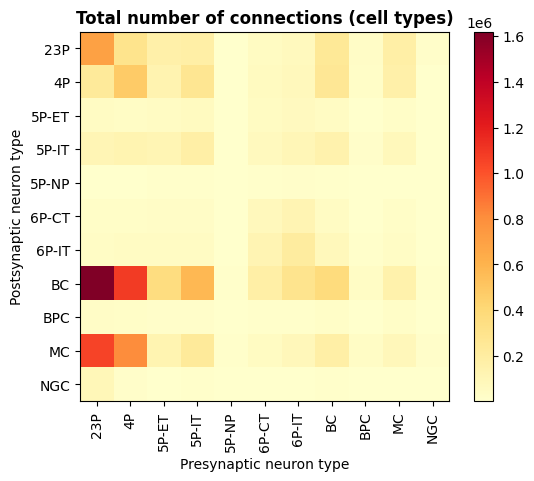

In [17]:
plot_cell_type_conn_matrix(clftype_mat, clf_type_space, 'Total number of connections', text_inside=True)
plot_cell_type_conn_matrix(mtype_mat, m_types, 'Total number of connections (morphological type)')
plot_cell_type_conn_matrix(mtype_mat, m_types, 'Total number of connections (morphological type)', remove=['PTC', 'DTC'])
plot_cell_type_conn_matrix(celltype_mat, cell_types, 'Total number of connections (cell types)', remove=[])